In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 17 22:32:01 2018

@author: hassan.naseri
"""

import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.tools.visualization import plot_circuit

from quantum_functions import uint4, black_box_check, reflection_about_average

import warnings
warnings.filterwarnings("ignore")

# This is the number of bits used to address the dataset
# In our example, the shelf number of a fruit is a 4 bit unsigned integer.
NBITS = 4;

In [6]:
# The name of fruit to search for its shelf number: 
# Options: apple, banana, orange, strawberry
fruit_to_find = 'orange'

# Define reqisters and circuit
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)
grover = QuantumCircuit(qreg, creg)

# Initialization of quantum registers
grover.h(qreg[0])
grover.h(qreg[1])

In [4]:
# Grover's amplitude amplification (only one iteration here)
black_box_check(grover, fruit_to_find, qreg)
reflection_about_average(grover, qreg)

# Add Measurement
grover.measure(qreg, creg)

# Execute and collect results
job_sim = execute(grover, "local_qasm_simulator", shots=10)
sim_result = job_sim.result()

# Print result counts
print("simulation: ", sim_result)
print(sim_result.get_counts(grover))

shelf = int(max(sim_result.get_counts(grover)), 2)
print("")
print("I found '{:}'! The shlef number is: {:}".format(fruit_to_find, shelf))

simulation:  COMPLETED
{'10': 10}

I found 'orange'! The shlef number is: 2


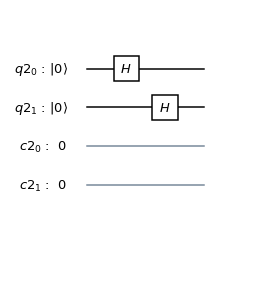

In [8]:
#print(grover.qasm())
plot_circuit(grover)